### Importing libraries

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import json
#nltk.download('all')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tensorflow.python.keras.preprocessing.text import Tokenizer
import re
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences


In [40]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.model_selection import train_test_split


### Load headlines dataset

In [16]:
headlines = []
with open(r"/content/drive/MyDrive/GL_NLP_SarcasmDetection/Sarcasm_Headlines_Dataset.json") as f:
  lines = f.readlines()
  for line in lines:
    line = re.sub('\n','',line)
    headlines.append(line)

In [17]:
headlines[0:10]

['{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret \'black code\' for minority shoppers", "is_sarcastic": 0}',
 '{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the \'roseanne\' revival catches up to our thorny political mood, for better and worse", "is_sarcastic": 0}',
 '{"article_link": "https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697", "headline": "mom starting to fear son\'s web series closest thing she will have to grandchild", "is_sarcastic": 1}',
 '{"article_link": "https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302", "headline": "boehner just wants wife to listen, not come up with alternative debt-reduction ideas", "is_sarcastic": 1}',
 '{"article_link": "https://www.huffingtonpost.com/entry/jk-rowling-wis

In [34]:
link = []
headline = []
is_sarcastic = []
keys = [json.loads(headlines[0]).keys()]
for item in headlines:
  item = json.loads(item)
  link.append(item['article_link'])
  headline.append(item['headline'])
  is_sarcastic.append(item['is_sarcastic'])



In [36]:
df = pd.DataFrame(list(zip(link,headline,is_sarcastic)), columns = ['article_link','headline','is_sarcastic'])

In [37]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


### Train test split

In [41]:
X = np.array(df['headline'])
y = np.array(df['is_sarcastic'])
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [44]:
print(x_train.shape)
print(x_test.shape)

(21367,)
(5342,)


#### Count of zeros and ones in train and test data

In [45]:
train_count = np.bincount(y_train)
i = np.nonzero(train_count)[0]
np.vstack((i, train_count[i])).T

array([[    0, 11989],
       [    1,  9378]])

In [46]:
test_count = np.bincount(y_test)
ii = np.nonzero(test_count)[0]
np.vstack((ii, test_count[ii])).T

array([[   0, 2996],
       [   1, 2346]])

### Text preprocessing

In [47]:
lemma = WordNetLemmatizer()

#### Custom transformer for textprocessing



In [48]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords

class TextPreprocessing(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
    
  def fit(self, train):
    self.train = train
  
  @staticmethod
  def remove_html(sentences):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    for i in range(len(sentences)):
      sentences[i] = re.sub(cleanr, '', sentences[i])
    return sentences
  
  @staticmethod
  def tokenize(sample):
    """Sentence Tokenizer"""
    sentences = sent_tokenize(sample)
    return sentences

  @staticmethod
  def remove_special_chars(sentences):
    """Removing special characters"""
    for i in range(len(sentences)):
      sentences[i] = re.sub("[^A-Za-z0-9]"," ",sentences[i])
    return sentences

  @staticmethod
  def remove_stopwords(sentences):
    """Removing stopwords"""
    stop_words = set(stopwords.words('english'))
    for i in range(len(sentences)):
      sentences[i] = " ".join(word for word in sentences[i].split() if word.lower not in stop_words)
    return sentences
  
  @staticmethod
  def lemmatize(sentences):
    """lemmatization"""
    for i in range(len(sentences)):
      sentences[i] = " ".join(lemma.lemmatize(word) for word in sentences[i].split())
    return sentences
  
  @staticmethod
  def remove_emojis(sentences):
    """removing emojis"""
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    for i in range(len(sentences)):
      sentences[i] = emoji.sub(r'',sentences[i])
    return sentences
  
  @staticmethod
  def remove_urls(sentences):
    """removing urls"""
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    for i in range(len(sentences)):
      sentences[i] = pattern.sub('',sentences[i])
    return sentences
  
  @staticmethod
  def to_lower(sentences):
    for i in range(len(sentences)):
      sentences[i] = sentences[i].lower()
    return sentences

  @staticmethod
  def fix_shortforms(sentences):
    """fix short forms"""

    for i in range(len(sentences)):
      sentences[i] = re.sub(r"i'm", "i am", sentences[i])
      sentences[i] = re.sub(r"he's", "he is", sentences[i])
      sentences[i] = re.sub(r"she's", "she is", sentences[i])
      sentences[i] = re.sub(r"that's", "that is", sentences[i])        
      sentences[i] = re.sub(r"what's", "what is", sentences[i])
      sentences[i] = re.sub(r"where's", "where is", sentences[i]) 
      sentences[i] = re.sub(r"\'ll", " will", sentences[i])  
      sentences[i] = re.sub(r"\'ve", " have", sentences[i])  
      sentences[i] = re.sub(r"\'re", " are", sentences[i])
      sentences[i] = re.sub(r"\'d", " would", sentences[i])
      sentences[i] = re.sub(r"\'ve", " have", sentences[i])
      sentences[i] = re.sub(r"won't", "will not", sentences[i])
      sentences[i] = re.sub(r"don't", "do not", sentences[i])
      sentences[i] = re.sub(r"did't", "did not", sentences[i])
      sentences[i] = re.sub(r"can't", "can not", sentences[i])
      sentences[i] = re.sub(r"it's", "it is", sentences[i])
      sentences[i] = re.sub(r"couldn't", "could not", sentences[i])
      sentences[i] = re.sub(r"have't", "have not", sentences[i])
      sentences[i] = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", sentences[i])
    return sentences
      

  def transform(self):
    data = []
    for sample in self.train:
      sent = self.tokenize(sample)
      sent = self.remove_stopwords(sent)
      sent = self.fix_shortforms(sent)
      sent = self.remove_special_chars(sent)
      sent = self.remove_emojis(sent)
      sent = self.remove_urls(sent)
      sent = self.lemmatize(sent)
      sent = self.to_lower(sent)
      data.append(sent[0])
    return np.array(data)




#### Creating wordcloud to see most frequent words in positive('1') and negative('0') sarcasms

In [50]:
from wordcloud import WordCloud, ImageColorGenerator
pos_data = np.array([review for idx,review in enumerate(x_train) if idx in np.where(y_train==1)[0] ])
neg_data = np.array([review for idx, review in enumerate(x_train) if idx in np.where(y_train==0)[0] ])


##### Transforming the data

In [51]:
#---for positive reviews---#
pro_pos = TextPreprocessing()
pro_pos.fit(pos_data)
pos_data_clean = pro_pos.transform()
#--for negative reviews---#
neg_pos = TextPreprocessing()
neg_pos.fit(neg_data)
neg_data_clean = neg_pos.transform()

##### splitting the words and storing the count in word dict

In [52]:
pos_data_words = [review.split() for review in pos_data_clean]
pos_data_words = [word for review in pos_data_words for word in review]
neg_data_words = [review.split() for review in neg_data_clean]
neg_data_words = [word for review in neg_data_words for word in review]

##### Count of the words in the corpus stored

In [53]:
from collections import Counter
pos_wordcloud_dict = Counter(pos_data_words)
neg_wordcloud_dict = Counter(neg_data_words)

##### Positive sarcasm wordcloud

(-0.5, 999.5, 499.5, -0.5)

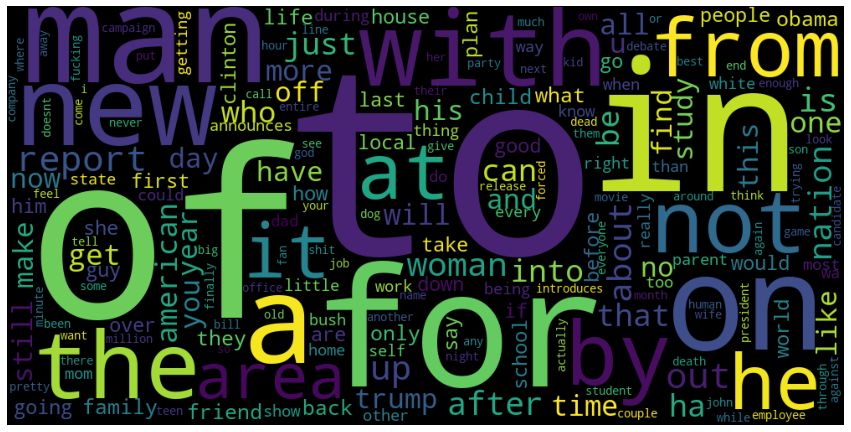

In [54]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(pos_wordcloud_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

##### Negative sarcasm wordcloud

(-0.5, 999.5, 499.5, -0.5)

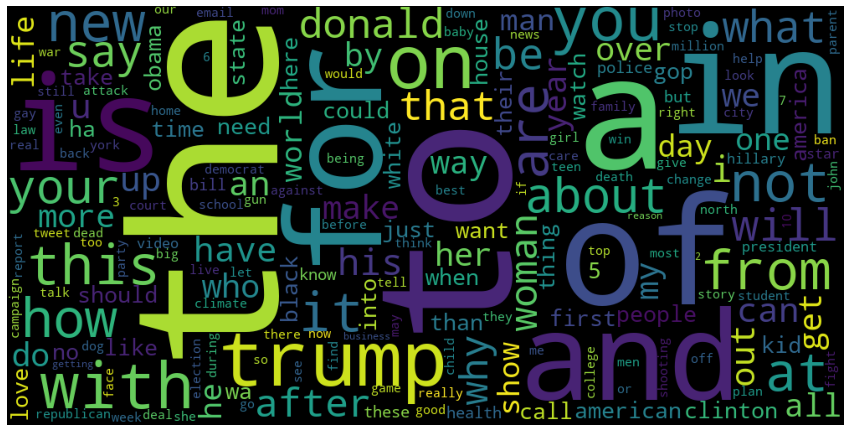

In [56]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(neg_wordcloud_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

### Preparation of train and test data from word index

#### Converting the training data into vectors of word indices

In [57]:
token_obj = Tokenizer()
#Data Preprocessing
preprocess = TextPreprocessing()
preprocess.fit(x_train)
x_train_transformed = preprocess.transform()
#converting to sequences of word indices
token_obj.fit_on_texts(x_train_transformed)
x_train_sequences = token_obj.texts_to_sequences(x_train_transformed)


In [62]:
preprocess.fit(x_test)
x_test_transformed = preprocess.transform()
x_test_sequences = token_obj.texts_to_sequences(x_test_transformed)

#### Word indices

In [63]:
word_index = token_obj.word_index
word_index

{'to': 1,
 'of': 2,
 'the': 3,
 'in': 4,
 'a': 5,
 'for': 6,
 'on': 7,
 'is': 8,
 'and': 9,
 'with': 10,
 'trump': 11,
 'new': 12,
 'man': 13,
 'not': 14,
 'from': 15,
 'at': 16,
 'it': 17,
 'you': 18,
 'about': 19,
 'this': 20,
 'by': 21,
 'woman': 22,
 'after': 23,
 'be': 24,
 'how': 25,
 'out': 26,
 'that': 27,
 'up': 28,
 'are': 29,
 'he': 30,
 'will': 31,
 'can': 32,
 'what': 33,
 'your': 34,
 'say': 35,
 'his': 36,
 'who': 37,
 'report': 38,
 'have': 39,
 'get': 40,
 'u': 41,
 'ha': 42,
 'just': 43,
 'more': 44,
 'one': 45,
 'all': 46,
 'make': 47,
 'into': 48,
 'area': 49,
 'day': 50,
 'time': 51,
 'donald': 52,
 'american': 53,
 'why': 54,
 'year': 55,
 'over': 56,
 'i': 57,
 'life': 58,
 'like': 59,
 'do': 60,
 'nation': 61,
 'no': 62,
 'her': 63,
 'people': 64,
 'world': 65,
 'way': 66,
 'first': 67,
 'an': 68,
 'we': 69,
 'obama': 70,
 'off': 71,
 'thing': 72,
 'now': 73,
 'show': 74,
 'house': 75,
 'take': 76,
 'than': 77,
 'clinton': 78,
 'family': 79,
 'wa': 80,
 'back': 

#### Function to convert sequences to text for analysis

In [64]:
inverse_map = dict(zip(word_index.values(), word_index.keys()))

In [65]:
def tokens_to_string(data):
  words = [inverse_map[token] for token in data if token != 0]
  text = " ".join(words)
  return text

In [66]:
print(x_train_sequences[0])
print(tokens_to_string(x_train_sequences[0]))

[2283, 353, 323, 13, 11370]
annoying ad turn man prowhaling


#### Padding of train and test data

In [67]:
word_count = [len(review) for review in x_train_transformed]
print(word_count)
max_len = int(np.mean(word_count) + 2*np.std(word_count))
print("Max Length = ", max_len)

[31, 64, 68, 43, 51, 93, 57, 27, 60, 38, 42, 60, 109, 65, 38, 56, 52, 103, 63, 65, 89, 76, 68, 65, 70, 32, 56, 80, 61, 80, 72, 73, 28, 55, 47, 64, 39, 52, 61, 50, 98, 61, 26, 51, 23, 78, 65, 63, 66, 73, 52, 84, 66, 23, 58, 56, 54, 55, 84, 61, 40, 64, 90, 51, 61, 62, 57, 37, 33, 56, 13, 83, 51, 73, 70, 51, 43, 62, 67, 29, 61, 69, 57, 78, 66, 40, 22, 52, 40, 66, 44, 44, 27, 65, 55, 13, 54, 67, 68, 71, 78, 94, 68, 22, 16, 56, 77, 50, 57, 60, 33, 76, 35, 9, 60, 89, 70, 124, 50, 52, 26, 32, 95, 41, 66, 57, 41, 65, 69, 73, 60, 49, 64, 68, 80, 52, 68, 84, 75, 85, 61, 60, 50, 59, 94, 60, 69, 72, 45, 50, 65, 42, 62, 51, 62, 57, 37, 40, 40, 45, 32, 45, 40, 63, 79, 78, 62, 67, 52, 67, 38, 48, 39, 20, 40, 29, 70, 25, 64, 40, 53, 45, 70, 100, 54, 62, 49, 87, 52, 34, 86, 75, 46, 77, 83, 49, 91, 47, 89, 113, 67, 54, 41, 32, 65, 87, 71, 78, 61, 63, 75, 108, 41, 54, 86, 28, 76, 62, 61, 81, 90, 79, 72, 49, 61, 52, 48, 69, 79, 30, 51, 71, 71, 36, 49, 34, 20, 66, 63, 67, 60, 59, 63, 69, 67, 54, 85, 60, 56

In [69]:
x_train_pad = pad_sequences(x_train_sequences,maxlen=max_len,padding='pre',truncating='pre')
x_train_pad.shape


(21367, 96)

In [68]:
x_test_pad = pad_sequences(x_test_sequences,maxlen=max_len,padding='pre',truncating='pre')
x_test_pad.shape

(5342, 96)

#### Loading glove model

In [71]:
embedding_index = {}
embedding_dim = 100
glove_dir = r"/content/drive/MyDrive/GL_NLP_SarcasmDetection/glove.6B.100d.txt"
with open(glove_dir,encoding = "utf-8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embedding_index[word] = coefs
print("length of Word vectors = ", len(embedding_index))

length of Word vectors =  400000


In [73]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
print("Shape of the embedding matrix = ",embedding_matrix.shape)
count = 0
for word, index in word_index.items():
  #---always use '.get' method with dictionaries like embedding_index since 
  #---it wont produce 'keyerror' exception when there is no key in the dictionary---#
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    count += 1
    embedding_matrix[index] =  embedding_vector
print(count)

Shape of the embedding matrix =  (22338, 100)
19300


In [74]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)

### Building the LSTM model

In [75]:
from keras.optimizers import Adam
optimizer = Adam(lr=1e-3)


In [83]:
n_timesteps = 10
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(units = 64,dropout=0.2, recurrent_dropout=0.25)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 96, 100)           2233800   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,318,409
Trainable params: 84,609
Non-trainable params: 2,233,800
_________________________________________________________________


In [87]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
                                min_delta=0, 
                                patience=0, 
                                verbose=0, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=False)

In [89]:
%%time
history = model.fit(x_train_pad,y_train,batch_size=64, epochs=5, callbacks=[callbacks],validation_data=(x_test_pad, y_test))

Epoch 1/5
334/334 [==============================] - 162s 485ms/step - loss: 0.3261 - acc: 0.8578 - val_loss: 0.3418 - val_acc: 0.8516
Epoch 2/5
334/334 [==============================] - 163s 487ms/step - loss: 0.3104 - acc: 0.8661 - val_loss: 0.3377 - val_acc: 0.8566
Epoch 3/5
334/334 [==============================] - 165s 494ms/step - loss: 0.2996 - acc: 0.8702 - val_loss: 0.3385 - val_acc: 0.8493
CPU times: user 17min 56s, sys: 3min 15s, total: 21min 11s
Wall time: 8min 9s


#### Visualization

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


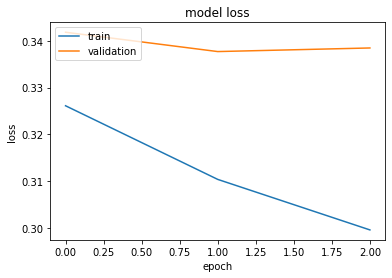

In [90]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


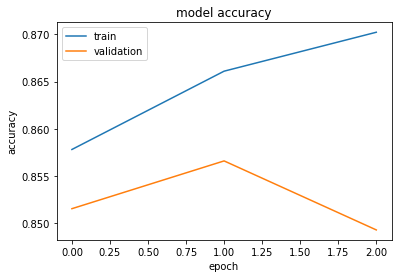

In [91]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [104]:
y_pred = model.predict_classes(x_test_pad)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [105]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      2996
           1       0.87      0.78      0.82      2346

    accuracy                           0.85      5342
   macro avg       0.85      0.84      0.84      5342
weighted avg       0.85      0.85      0.85      5342

